# City2TABULA Validation Notebook

This notebook validates the calculations performed by the City2TABULA pipeline by comparing calculated building attributes against source thematic data from CityGML/CityJSON datasets.

## Validation Strategy

1. **Building-Level Attributes**: Height, footprint area, aggregated surface areas
2. **Surface-Level Attributes**: Individual surface area, tilt (roof only), azimuth (roof only)

The validation uses a configuration-driven approach where source property names are mapped to City2TABULA calculated columns via YAML configuration files.

## Stage 0: Load Configuration and Setup Database Connection

Load the validation configuration from YAML file based on the `COUNTRY` environment variable. The configuration contains:
- Dataset information and metadata
- Attribute mappings (source property names → City2TABULA columns)
- Database connection settings (automatically configured)
- Validation tolerances

In [2]:
# Add parent directory to Python path to import validation modules
import sys
import os

# Get the notebook directory
notebook_dir = os.getcwd()
print(f"Notebook directory: {notebook_dir}")

# Add to path (no need to go up if already in validation/)
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)

# Now import from modules
from modules.config import load_config, print_config_summary
from modules.db import get_db_engine

# Get country from environment variable
country = os.getenv('COUNTRY', 'germany').lower()

# Build path to config file
config_path = os.path.join('configs', f'config_{country}.yaml')

# Load configuration
print(f"\nLoading configuration from: config_{country}.yaml")
config = load_config(config_path)

# Display configuration summary
print_config_summary(config)

# Set up output directory
output_dir = os.path.join('outputs')
os.makedirs(output_dir, exist_ok=True)
print(f"\nOutput directory: {output_dir}")

# Initialize database engine
print("\nInitializing database connection...")
db_engine = get_db_engine(config)
print(f"Connected to database: city2tabula_{country}")

Notebook directory: /home/jayravani/Projects/Work/City2TABULA/github/City2TABULA/validation

Loading configuration from: config_germany.yaml
Loaded configuration for: Germany

CONFIGURATION SUMMARY

 Dataset: LoD2 Dataset of Bavaria
   Country: Germany
   LoD: 2
   Description: Bavarian 3D city models in CityGML format with German property names

 Building Attributes:
   min_height           <- 'value' (m)
   footprint_area       <- 'Flaeche' (m²)

 Surface Attributes:
   ROOF:
   surface_area         <- 'Flaeche' (m²)
   tilt                 <- 'Dachneigung' (degrees)
   azimuth              <- 'Dachorientierung' (degrees)
   WALL:
   surface_area         <- 'Flaeche' (m²)
   FLOOR:
   surface_area         <- 'Flaeche' (m²)

 Validation Tolerances:
   Absolute:
   height               ±0.5
   tilt                 ±2.0
   azimuth              ±5.0
   Percentage:
   footprint_area       ±5.0%
   surface_area         ±5.0%

Output directory: outputs

Initializing database connection...
C

## Stage 1: Load Data from PostgreSQL Database

Load calculated data from City2TABULA tables and extract attribute mappings from config.

In [3]:
from modules.utils import load_city2tabula_data

# Load calculated data from City2TABULA tables
bf_df, sf_df = load_city2tabula_data(db_engine, config)

print("\nData loading complete.")
display(bf_df.head())
display(sf_df.head())

Loading building features from city2tabula.lod2_building_feature...
Loaded 1371 buildings
Loading surface features from city2tabula.lod2_child_feature_surface...
Loaded 21662 surfaces

Data loading complete.


,id,building_feature_id,tabula_variant_code_id,tabula_variant_code,construction_year,comment,heating_demand,heating_demand_unit,footprint_area,footprint_complexity,...,area_total_roof_unit,area_total_wall,area_total_wall_unit,area_total_floor,area_total_floor_unit,surface_count_floor,surface_count_roof,surface_count_wall,building_centroid_geom,building_footprint_geom
0,a7697e80-40d7-46d2-9cd7-4df5672281b7,5758,130,DE.N.TH.05.Gen.ReEx.001.001,None,None,None,None,15.358336,1,...,sqm,31.294622,sqm,15.358336,sqm,0,1,4,0101000020E8640000B9369C3200FB2741267C9B580FA7...,01060000A0E86400000100000001030000800100000005...
1,5efaf9a2-8c85-4ebc-acdb-af9cdf0eb486,11452,130,DE.N.TH.05.Gen.ReEx.001.001,None,None,None,None,25.926250,1,...,sqm,49.198265,sqm,25.926250,sqm,0,1,4,0101000020E86400007B6009C81DFA27414BBCA74DEBA6...,01060000A0E86400000100000001030000800100000005...
2,dc9a176a-01b1-495a-93c0-eabdc29dbf64,12224,40,DE.N.MFH.07.Gen.ReEx.001.001,None,None,None,None,200.027949,2,...,sqm,433.772740,sqm,800.111798,sqm,0,6,16,0101000020E86400005DC0193C8AFF2741EA35550A86A5...,01060000A0E86400000100000001030000800100000014...
3,553d9519-110e-4053-939a-0467faf4e9fd,12244,85,DE.N.SFH.06.Gen.ReEx.001.001,None,None,None,None,169.431553,2,...,sqm,188.141832,sqm,508.294659,sqm,0,3,11,0101000020E864000058A271339AFF27413962373190A5...,01060000A0E86400000100000001030000800200000014...
4,3bf32cae-0cb3-4747-bc1a-841f921c8709,12278,70,DE.N.SFH.01.Gen.ReEx.001.001,None,None,None,None,109.491468,2,...,sqm,182.004933,sqm,328.474404,sqm,0,3,8,0101000020E8640000EA3BBC61A5FF27414C270B499BA5...,01060000A0E8640000010000000103000080010000000C...


,id,building_feature_id,surface_feature_id,objectclass_id,classname,height,height_unit,surface_area,surface_area_unit,tilt,tilt_unit,azimuth,azimuth_unit,is_valid,is_planar,child_row_id,attribute_calc_status,geom
0,78e7da8f-a2f3-47c6-a892-2005e4ad6087,14818,14850,709,WallSurface,9.920,m,13.543616,sqm,0.000000,degrees,5.042451,degrees,False,True,397ba23b-0f1d-44ec-802f-29d34c5e4d65,None,01030000A0E86400000100000005000000295C8F421BFD...
1,1a1859ac-208f-40bb-9e68-9c2e6880cbab,15721,15731,709,WallSurface,7.839,m,157.268079,sqm,0.000000,degrees,138.597294,degrees,True,True,5e10b94d-3888-4ccb-a7aa-59a261398302,None,01030000A0E864000001000000070000009A9999993703...
2,0553e6f0-a8cc-4aeb-b727-1a67235090d9,15149,15154,709,WallSurface,2.504,m,16.475596,sqm,0.000000,degrees,242.909314,degrees,False,True,69bfd784-11e0-4bc5-9c9d-3fa060538b31,None,01030000A0E864000001000000050000004E62105879FF...
3,5a943cfa-edb0-400b-9068-0d6bb96649c4,16327,16332,712,RoofSurface,0.595,m,93.606414,sqm,84.470246,degrees,-1.000000,degrees,True,True,a0dcf4f9-489c-451f-b9fb-9949872f03d0,None,01030000A0E864000001000000060000003D0AD7A385FE...
4,9adc76b2-9644-41d3-8549-2081341759d9,15293,15299,709,WallSurface,2.462,m,6.682115,sqm,0.000000,degrees,174.587688,degrees,False,True,df44b2fd-0f92-45b2-84f9-3dc9fa810d7e,None,01030000A0E864000001000000050000005C8FC2B525FE...


## Stage 2: Validate Surface Attributes

Validate calculated surface attributes (area, tilt, azimuth) against source thematic data.

In [4]:
from modules.utils import load_thematic_building_data, load_thematic_surface_data
from modules.validators import validate_building_attributes, validate_surface_attributes, get_validation_summary
from modules.config import get_building_attribute_mapping, get_surface_attribute_mapping
import pandas as pd

# =============================================================================
# BUILDING-LEVEL VALIDATION
# =============================================================================
print("="*80)
print("BUILDING-LEVEL ATTRIBUTE VALIDATION")
print("="*80)

# Get building attribute mapping
building_attr_map = get_building_attribute_mapping(config)
print(f"\nValidating {len(building_attr_map)} building attributes:")
for attr, label in building_attr_map.items():
    print(f"  • {attr}: '{label}'")

# Get building IDs
building_ids = bf_df['building_feature_id'].tolist()
print(f"\nBuildings to validate: {len(building_ids)}")

# Load thematic data from CityDB
building_thematic_df = load_thematic_building_data(
    engine=db_engine,
    config=config,
    building_feature_ids=building_ids,
    attribute_mapping=building_attr_map
)

# Validate building attributes
building_validation_df = validate_building_attributes(
    building_calc_df=bf_df,
    building_thematic_df=building_thematic_df,
    attribute_mapping=building_attr_map
)

# Display summary
if not building_validation_df.empty:
    building_summary = get_validation_summary(building_validation_df)
    print("\n" + "="*80)
    print("BUILDING VALIDATION SUMMARY")
    print("="*80)
    display(building_summary)
else:
    print("⚠️  No building validation results")

# =============================================================================
# SURFACE-LEVEL VALIDATION (ROOFS)
# =============================================================================
print("\n" + "="*80)
print("ROOF SURFACE ATTRIBUTE VALIDATION")
print("="*80)

# Get roof attribute mapping
roof_attr_map = get_surface_attribute_mapping(config, 'roof')
print(f"\nValidating {len(roof_attr_map)} roof attributes:")
for attr, label in roof_attr_map.items():
    print(f"  • {attr}: '{label}'")

# Filter for roof surfaces
roof_surfaces_df = sf_df[sf_df['classname'] == 'RoofSurface'].copy()
roof_ids = roof_surfaces_df['surface_feature_id'].tolist()
print(f"\nRoof surfaces to validate: {len(roof_ids)}")

if roof_ids:
    # Load thematic data from CityDB
    roof_thematic_df = load_thematic_surface_data(
        engine=db_engine,
        config=config,
        surface_feature_ids=roof_ids,
        attribute_mapping=roof_attr_map,
        surface_type='RoofSurface'
    )

    # Validate roof attributes
    roof_validation_df = validate_surface_attributes(
        surface_calc_df=sf_df,
        surface_thematic_df=roof_thematic_df,
        attribute_mapping=roof_attr_map,
        surface_type='RoofSurface'
    )

    # Display summary
    if not roof_validation_df.empty:
        roof_summary = get_validation_summary(roof_validation_df)
        print("\n" + "="*80)
        print("ROOF VALIDATION SUMMARY")
        print("="*80)
        display(roof_summary)
    else:
        print("⚠️  No roof validation results")
else:
    print("⚠️  No roof surfaces found")
    roof_validation_df = pd.DataFrame()

# =============================================================================
# SURFACE-LEVEL VALIDATION (WALLS)
# =============================================================================
print("\n" + "="*80)
print("WALL SURFACE ATTRIBUTE VALIDATION")
print("="*80)

# Get wall attribute mapping
wall_attr_map = get_surface_attribute_mapping(config, 'wall')
print(f"\nValidating {len(wall_attr_map)} wall attributes:")
for attr, label in wall_attr_map.items():
    print(f"  • {attr}: '{label}'")

# Filter for wall surfaces
wall_surfaces_df = sf_df[sf_df['classname'] == 'WallSurface'].copy()
wall_ids = wall_surfaces_df['surface_feature_id'].tolist()
print(f"\nWall surfaces to validate: {len(wall_ids)}")

if wall_ids and wall_attr_map:
    # Load thematic data from CityDB
    wall_thematic_df = load_thematic_surface_data(
        engine=db_engine,
        config=config,
        surface_feature_ids=wall_ids,
        attribute_mapping=wall_attr_map,
        surface_type='WallSurface'
    )

    # Validate wall attributes
    wall_validation_df = validate_surface_attributes(
        surface_calc_df=sf_df,
        surface_thematic_df=wall_thematic_df,
        attribute_mapping=wall_attr_map,
        surface_type='WallSurface'
    )

    # Display summary
    if not wall_validation_df.empty:
        wall_summary = get_validation_summary(wall_validation_df)
        print("\n" + "="*80)
        print("WALL VALIDATION SUMMARY")
        print("="*80)
        display(wall_summary)
    else:
        print("⚠️  No wall validation results")
else:
    print("⚠️  No wall surfaces or attributes to validate")
    wall_validation_df = pd.DataFrame()

# =============================================================================
# SURFACE-LEVEL VALIDATION (FLOORS/GROUND)
# =============================================================================
print("\n" + "="*80)
print("FLOOR/GROUND SURFACE ATTRIBUTE VALIDATION")
print("="*80)

# Get floor attribute mapping
floor_attr_map = get_surface_attribute_mapping(config, 'floor')
print(f"\nValidating {len(floor_attr_map)} floor attributes:")
for attr, label in floor_attr_map.items():
    print(f"  • {attr}: '{label}'")

# Filter for ground surfaces
floor_surfaces_df = sf_df[sf_df['classname'] == 'GroundSurface'].copy()
floor_ids = floor_surfaces_df['surface_feature_id'].tolist()
print(f"\nFloor/Ground surfaces to validate: {len(floor_ids)}")

if floor_ids and floor_attr_map:
    # Load thematic data from CityDB
    floor_thematic_df = load_thematic_surface_data(
        engine=db_engine,
        config=config,
        surface_feature_ids=floor_ids,
        attribute_mapping=floor_attr_map,
        surface_type='GroundSurface'
    )

    # Validate floor attributes
    floor_validation_df = validate_surface_attributes(
        surface_calc_df=sf_df,
        surface_thematic_df=floor_thematic_df,
        attribute_mapping=floor_attr_map,
        surface_type='GroundSurface'
    )

    # Display summary
    if not floor_validation_df.empty:
        floor_summary = get_validation_summary(floor_validation_df)
        print("\n" + "="*80)
        print("FLOOR/GROUND VALIDATION SUMMARY")
        print("="*80)
        display(floor_summary)
    else:
        print("⚠️  No floor validation results")
else:
    print("⚠️  No floor/ground surfaces or attributes to validate")
    floor_validation_df = pd.DataFrame()

BUILDING-LEVEL ATTRIBUTE VALIDATION

Validating 2 building attributes:
  • min_height: 'value'
  • footprint_area: 'Flaeche'

Buildings to validate: 1371
Loaded thematic data for 1371 building attribute values
Validated 1371 building attribute values across 1371 buildings

BUILDING VALIDATION SUMMARY


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,min_height,1371,0.7444,2.1966,2.3186,20.3436,0.0,54.8912



ROOF SURFACE ATTRIBUTE VALIDATION

Validating 3 roof attributes:
  • surface_area: 'Flaeche'
  • tilt: 'Dachneigung'
  • azimuth: 'Dachorientierung'

Roof surfaces to validate: 4542
Loaded thematic data for 10497 RoofSurface attribute values
Validated 13626 RoofSurface attribute values across 3499 surfaces

ROOF VALIDATION SUMMARY


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,azimuth,4542,-25.3048,93.1252,96.4921,13.3981,-0.0000,608.6952
1,surface_area,4542,-1.7579,24.5235,24.5838,-1.3583,-0.0001,8.5735
2,tilt,4542,-15.8228,45.0761,47.7678,-22.6634,0.0000,63.0324



WALL SURFACE ATTRIBUTE VALIDATION

Validating 1 wall attributes:
  • surface_area: 'Flaeche'

Wall surfaces to validate: 15068
Loaded thematic data for 10873 WallSurface attribute values
Validated 15068 WallSurface attribute values across 10873 surfaces

WALL VALIDATION SUMMARY


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,surface_area,15068,-2.86,43.3579,43.4507,-2.2269,0.0001,15.7103



FLOOR/GROUND SURFACE ATTRIBUTE VALIDATION

Validating 1 floor attributes:
  • surface_area: 'Flaeche'

Floor/Ground surfaces to validate: 2052
Loaded thematic data for 1371 GroundSurface attribute values
Validated 2052 GroundSurface attribute values across 1371 surfaces

FLOOR/GROUND VALIDATION SUMMARY


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,surface_area,2052,0.0446,0.8065,0.8076,0.0063,0.0,0.0263


In [5]:
# =============================================================================
# SAVE VALIDATION RESULTS
# =============================================================================
import os
from datetime import datetime

# Create timestamped output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_dir = os.path.join(output_dir, f"validation_{timestamp}")
os.makedirs(results_dir, exist_ok=True)

print(f"\nSaving validation results to: {results_dir}")

# Save building validation results
if not building_validation_df.empty:
    building_output = os.path.join(results_dir, "building_validation.csv")
    building_validation_df.to_csv(building_output, index=False)
    print(f"✓ Saved building validation: {building_output}")
    
    building_summary_output = os.path.join(results_dir, "building_summary.csv")
    building_summary.to_csv(building_summary_output, index=False)
    print(f"✓ Saved building summary: {building_summary_output}")

# Save roof validation results
if not roof_validation_df.empty:
    roof_output = os.path.join(results_dir, "roof_validation.csv")
    roof_validation_df.to_csv(roof_output, index=False)
    print(f"✓ Saved roof validation: {roof_output}")
    
    roof_summary_output = os.path.join(results_dir, "roof_summary.csv")
    roof_summary.to_csv(roof_summary_output, index=False)
    print(f"✓ Saved roof summary: {roof_summary_output}")

# Save wall validation results
if not wall_validation_df.empty:
    wall_output = os.path.join(results_dir, "wall_validation.csv")
    wall_validation_df.to_csv(wall_output, index=False)
    print(f"✓ Saved wall validation: {wall_output}")
    
    wall_summary_output = os.path.join(results_dir, "wall_summary.csv")
    wall_summary.to_csv(wall_summary_output, index=False)
    print(f"✓ Saved wall summary: {wall_summary_output}")

# Save floor validation results
if not floor_validation_df.empty:
    floor_output = os.path.join(results_dir, "floor_validation.csv")
    floor_validation_df.to_csv(floor_output, index=False)
    print(f"✓ Saved floor validation: {floor_output}")
    
    floor_summary_output = os.path.join(results_dir, "floor_summary.csv")
    floor_summary.to_csv(floor_summary_output, index=False)
    print(f"✓ Saved floor summary: {floor_summary_output}")

print(f"\n{'='*80}")
print("✅ RESULTS SAVED")
print(f"{'='*80}")


Saving validation results to: outputs/validation_20251126_195336
✓ Saved building validation: outputs/validation_20251126_195336/building_validation.csv
✓ Saved building summary: outputs/validation_20251126_195336/building_summary.csv
✓ Saved roof validation: outputs/validation_20251126_195336/roof_validation.csv
✓ Saved roof summary: outputs/validation_20251126_195336/roof_summary.csv
✓ Saved wall validation: outputs/validation_20251126_195336/wall_validation.csv
✓ Saved wall summary: outputs/validation_20251126_195336/wall_summary.csv
✓ Saved floor validation: outputs/validation_20251126_195336/floor_validation.csv
✓ Saved floor summary: outputs/validation_20251126_195336/floor_summary.csv

✅ RESULTS SAVED


## Stage 3: Generate Validation Plots

Create scatter plots and error distribution visualizations for validated attributes.

GENERATING VALIDATION PLOTS

📊 Generating building attribute plots...
  • Plotting: min_height
Saved plot: outputs/validation_20251126_195336/plots/building_min_height_scatter.png
Saved plot: outputs/validation_20251126_195336/plots/building_min_height_error_dist.png
Saved plot: outputs/validation_20251126_195336/plots/building_min_height_percent_error.png

📊 Generating roof surface attribute plots...
  • Plotting: surface_area
Saved plot: outputs/validation_20251126_195336/plots/roof_surface_area_scatter.png
Saved plot: outputs/validation_20251126_195336/plots/roof_surface_area_error_dist.png
Saved plot: outputs/validation_20251126_195336/plots/roof_surface_area_percent_error.png
  • Plotting: tilt
Saved plot: outputs/validation_20251126_195336/plots/roof_tilt_scatter.png
Saved plot: outputs/validation_20251126_195336/plots/roof_tilt_error_dist.png
Saved plot: outputs/validation_20251126_195336/plots/roof_tilt_percent_error.png
  • Plotting: azimuth
Saved plot: outputs/validation_2025

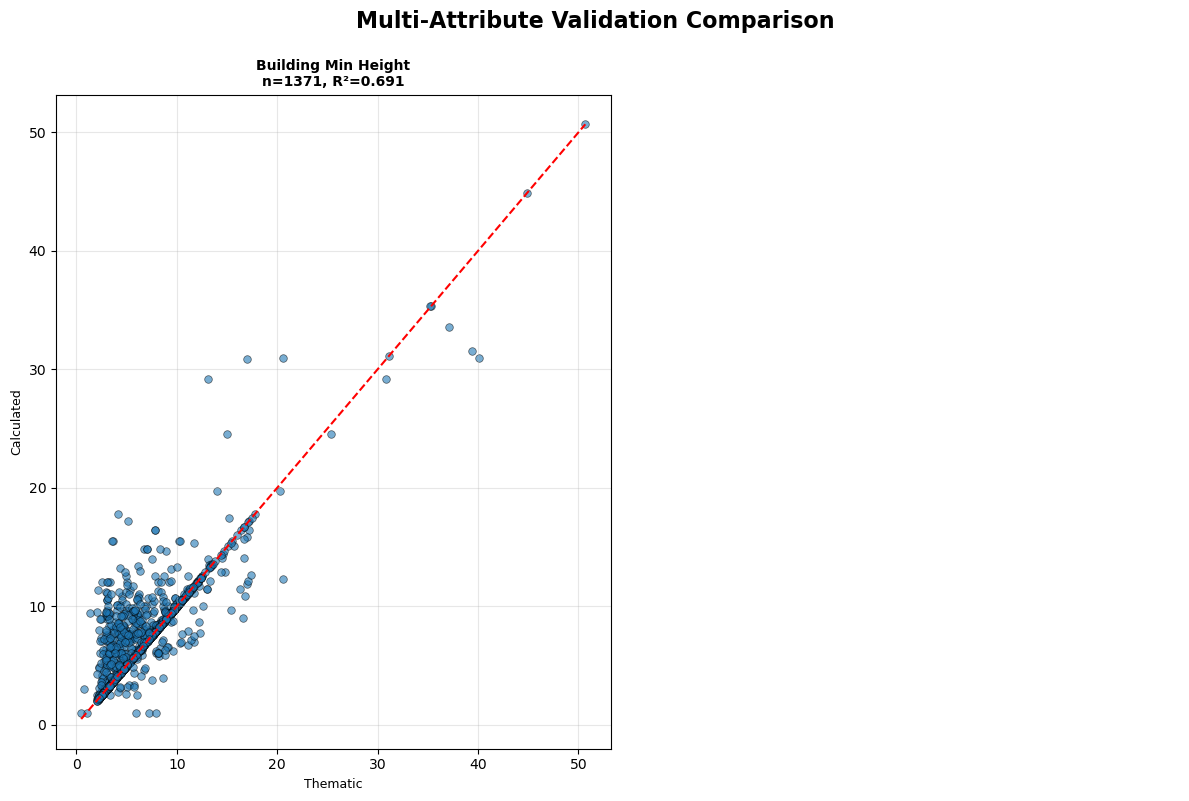

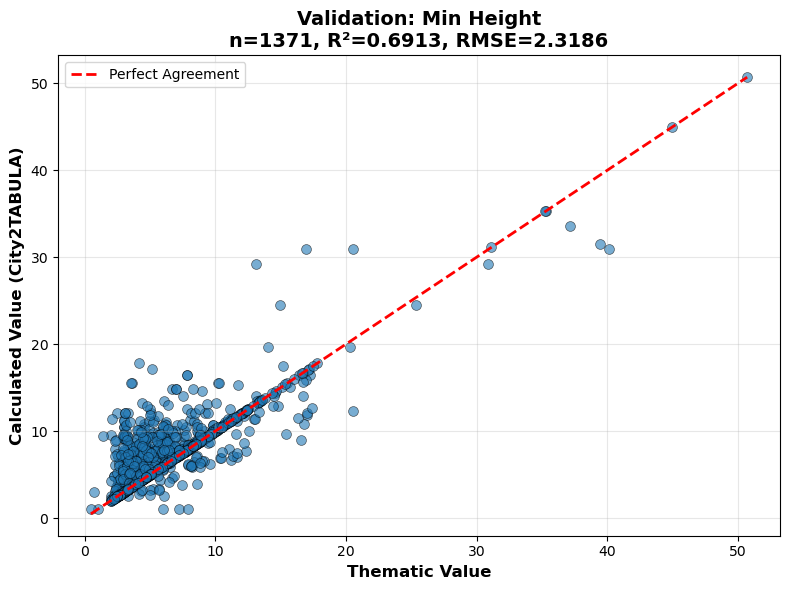

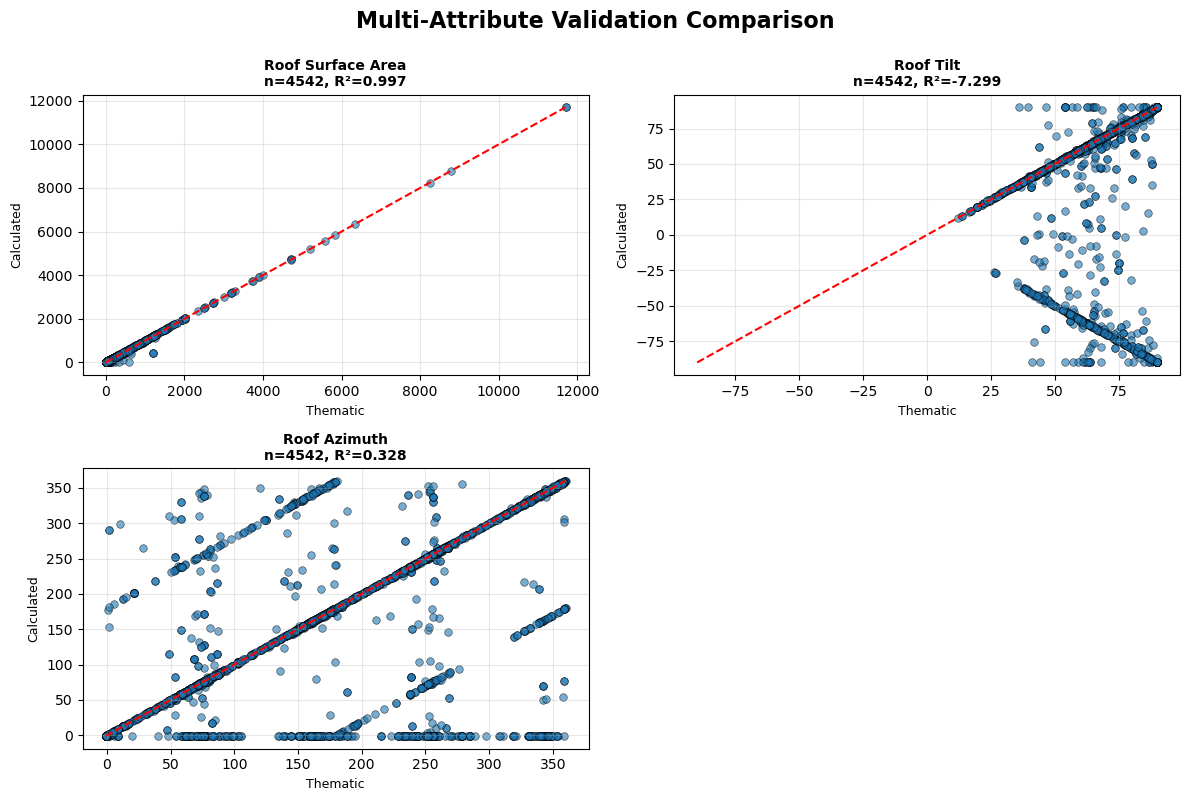

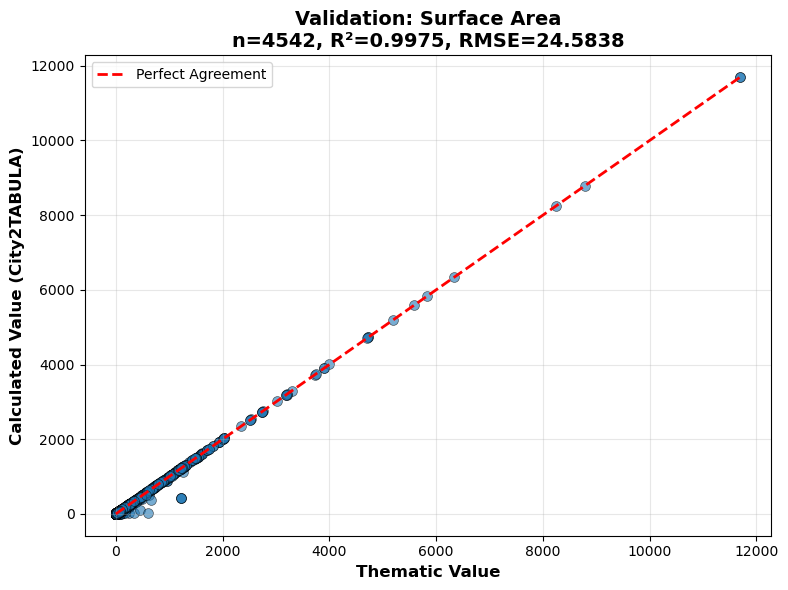

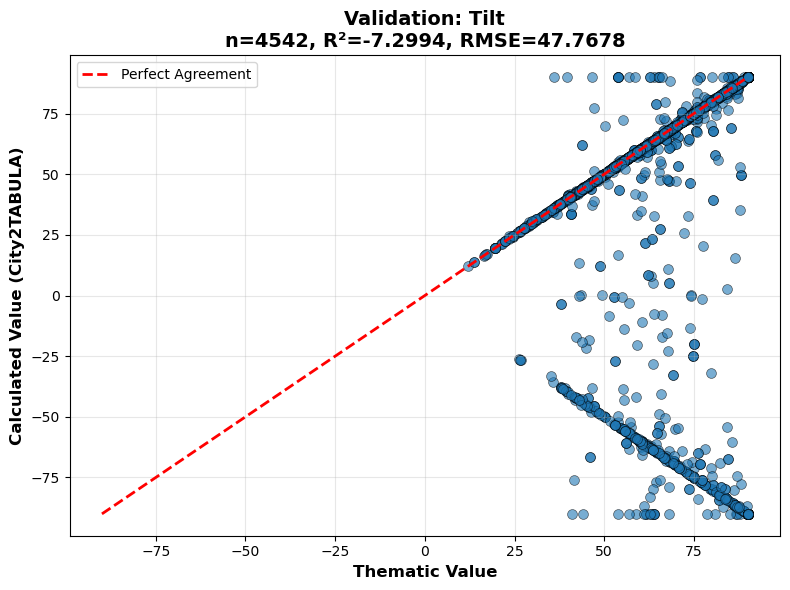

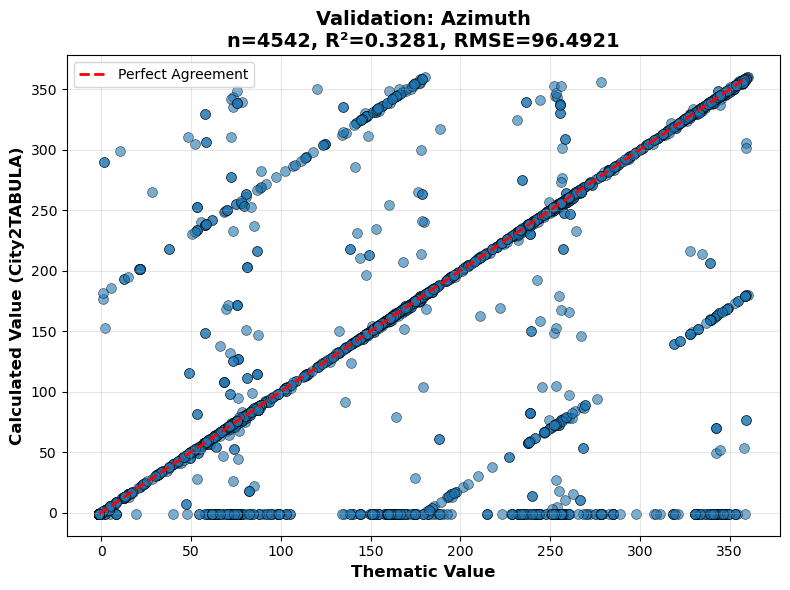

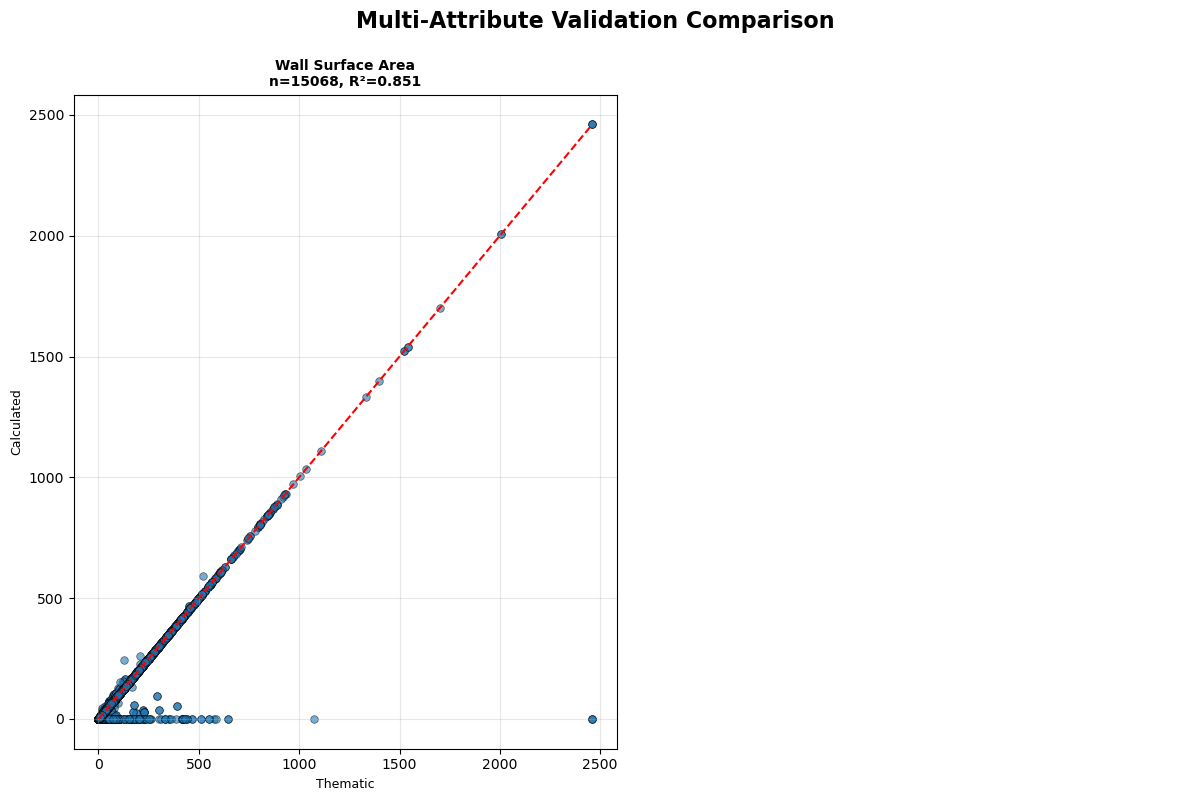

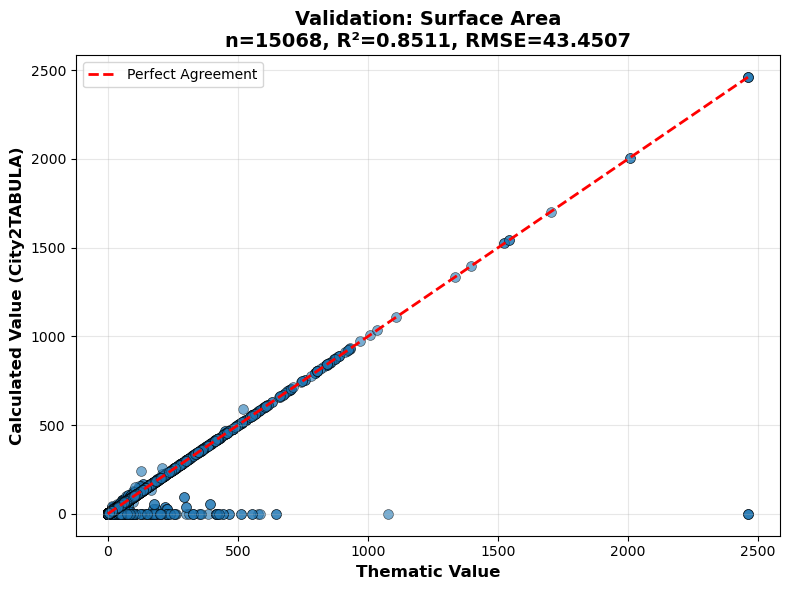

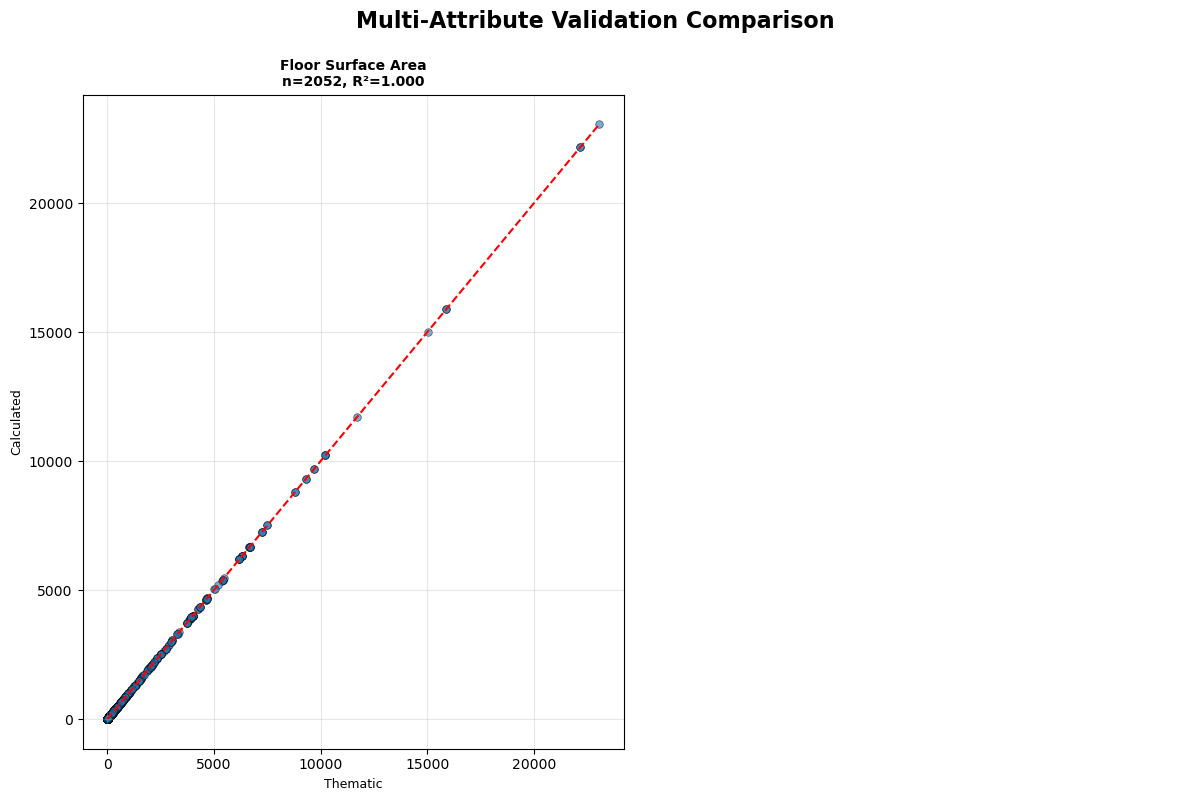

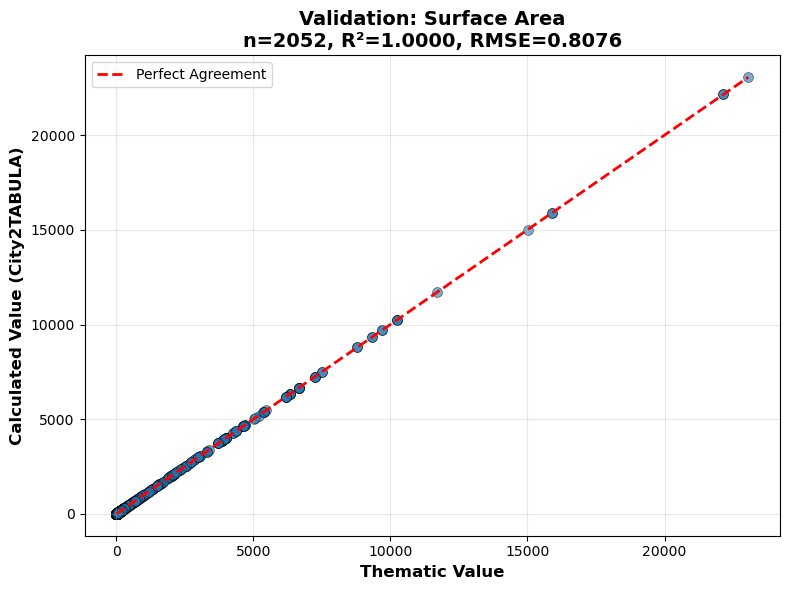

In [ ]:
from modules.plots import (plot_comparison_scatter, plot_error_distribution, 
                            plot_percent_error_distribution, plot_multi_attribute_comparison)
import matplotlib.pyplot as plt

# Create plots subdirectory
plots_dir = os.path.join(results_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

print("="*80)
print("GENERATING VALIDATION PLOTS")
print("="*80)

# =============================================================================
# BUILDING ATTRIBUTE PLOTS
# =============================================================================
if not building_validation_df.empty:
    print("\n📊 Generating building attribute plots...")
    print(building_validation_df.head())
    # Multi-attribute comparison
    plot_multi_attribute_comparison(
        building_validation_df,
        save_path=os.path.join(plots_dir, "building_multi_comparison.png"),
        title_prefix="Building"
    )
    
    # Individual attribute plots
    for attr in building_validation_df['attribute_name'].unique():
        print(f"  • Plotting: {attr}")
        
        plot_comparison_scatter(
            building_validation_df, attr,
            save_path=os.path.join(plots_dir, f"building_{attr}_scatter.png")
        )
        
        plot_error_distribution(
            building_validation_df, attr,
            save_path=os.path.join(plots_dir, f"building_{attr}_error_dist.png")
        )
        
        plot_percent_error_distribution(
            building_validation_df, attr,
            save_path=os.path.join(plots_dir, f"building_{attr}_percent_error.png")
        )

# =============================================================================
# ROOF SURFACE ATTRIBUTE PLOTS
# =============================================================================
if not roof_validation_df.empty:
    print("\n📊 Generating roof surface attribute plots...")
    
    plot_multi_attribute_comparison(
        roof_validation_df,
        save_path=os.path.join(plots_dir, "roof_multi_comparison.png"),
        title_prefix="Roof"
    )
    
    for attr in roof_validation_df['attribute_name'].unique():
        print(f"  • Plotting: {attr}")
        
        plot_comparison_scatter(
            roof_validation_df, attr,
            save_path=os.path.join(plots_dir, f"roof_{attr}_scatter.png")
        )
        
        plot_error_distribution(
            roof_validation_df, attr,
            save_path=os.path.join(plots_dir, f"roof_{attr}_error_dist.png")
        )
        
        plot_percent_error_distribution(
            roof_validation_df, attr,
            save_path=os.path.join(plots_dir, f"roof_{attr}_percent_error.png")
        )

# =============================================================================
# WALL SURFACE ATTRIBUTE PLOTS
# =============================================================================
if not wall_validation_df.empty:
    print("\n📊 Generating wall surface attribute plots...")
    
    plot_multi_attribute_comparison(
        wall_validation_df,
        save_path=os.path.join(plots_dir, "wall_multi_comparison.png"),
        title_prefix="Wall"
    )
    
    for attr in wall_validation_df['attribute_name'].unique():
        print(f"  • Plotting: {attr}")
        
        plot_comparison_scatter(
            wall_validation_df, attr,
            save_path=os.path.join(plots_dir, f"wall_{attr}_scatter.png")
        )
        
        plot_error_distribution(
            wall_validation_df, attr,
            save_path=os.path.join(plots_dir, f"wall_{attr}_error_dist.png")
        )
        
        plot_percent_error_distribution(
            wall_validation_df, attr,
            save_path=os.path.join(plots_dir, f"wall_{attr}_percent_error.png")
        )

# =============================================================================
# FLOOR SURFACE ATTRIBUTE PLOTS
# =============================================================================
if not floor_validation_df.empty:
    print("\n📊 Generating floor surface attribute plots...")
    
    plot_multi_attribute_comparison(
        floor_validation_df,
        save_path=os.path.join(plots_dir, "floor_multi_comparison.png"),
        title_prefix="Floor"
    )
    
    for attr in floor_validation_df['attribute_name'].unique():
        print(f"  • Plotting: {attr}")
        
        plot_comparison_scatter(
            floor_validation_df, attr,
            save_path=os.path.join(plots_dir, f"floor_{attr}_scatter.png")
        )
        
        plot_error_distribution(
            floor_validation_df, attr,
            save_path=os.path.join(plots_dir, f"floor_{attr}_error_dist.png")
        )
        
        plot_percent_error_distribution(
            floor_validation_df, attr,
            save_path=os.path.join(plots_dir, f"floor_{attr}_percent_error.png")
        )

print(f"\n✅ All plots saved to: {plots_dir}")
print("ℹ️  Plots are saved to disk but not displayed in notebook to reduce file size.")

## Stage 4: Interpretation & Summary

Review the validation results and summary statistics.

In [7]:
print("="*80)
print("VALIDATION SUMMARY REPORT")
print("="*80)

# =============================================================================
# BUILDING VALIDATION SUMMARY
# =============================================================================
if not building_validation_df.empty:
    print("\n" + "="*80)
    print("📋 BUILDING ATTRIBUTE VALIDATION")
    print("="*80)
    print(f"\nTotal buildings validated: {building_validation_df['building_feature_id'].nunique()}")
    print(f"Total comparisons: {len(building_validation_df)}")
    print("\nValidation Statistics:")
    display(building_summary)
else:
    print("\n⚠️ No building validation data available")

# =============================================================================
# ROOF SURFACE VALIDATION SUMMARY
# =============================================================================
if not roof_validation_df.empty:
    print("\n" + "="*80)
    print("🏠 ROOF SURFACE ATTRIBUTE VALIDATION")
    print("="*80)
    print(f"\nTotal roof surfaces validated: {roof_validation_df['surface_feature_id'].nunique()}")
    print(f"Total comparisons: {len(roof_validation_df)}")
    print("\nValidation Statistics:")
    display(roof_summary)
else:
    print("\n⚠️ No roof surface validation data available")

# =============================================================================
# WALL SURFACE VALIDATION SUMMARY
# =============================================================================
if not wall_validation_df.empty:
    print("\n" + "="*80)
    print("🧱 WALL SURFACE ATTRIBUTE VALIDATION")
    print("="*80)
    print(f"\nTotal wall surfaces validated: {wall_validation_df['surface_feature_id'].nunique()}")
    print(f"Total comparisons: {len(wall_validation_df)}")
    print("\nValidation Statistics:")
    display(wall_summary)
else:
    print("\n⚠️ No wall surface validation data available")

# =============================================================================
# FLOOR SURFACE VALIDATION SUMMARY
# =============================================================================
if not floor_validation_df.empty:
    print("\n" + "="*80)
    print("🟫 FLOOR SURFACE ATTRIBUTE VALIDATION")
    print("="*80)
    print(f"\nTotal floor surfaces validated: {floor_validation_df['surface_feature_id'].nunique()}")
    print(f"Total comparisons: {len(floor_validation_df)}")
    print("\nValidation Statistics:")
    display(floor_summary)
else:
    print("\n⚠️ No floor surface validation data available")

# =============================================================================
# OVERALL SUMMARY
# =============================================================================
print("\n" + "="*80)
print("📊 OVERALL VALIDATION SUMMARY")
print("="*80)

total_validations = 0
if not building_validation_df.empty:
    total_validations += len(building_validation_df)
if not roof_validation_df.empty:
    total_validations += len(roof_validation_df)
if not wall_validation_df.empty:
    total_validations += len(wall_validation_df)
if not floor_validation_df.empty:
    total_validations += len(floor_validation_df)

print(f"\n✅ Total validation comparisons: {total_validations}")
print(f"📁 Results directory: {results_dir}")
print("\n" + "="*80)

VALIDATION SUMMARY REPORT

📋 BUILDING ATTRIBUTE VALIDATION

Total buildings validated: 1371
Total comparisons: 1371

Validation Statistics:


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,min_height,1371,0.7444,2.1966,2.3186,20.3436,0.0,54.8912



🏠 ROOF SURFACE ATTRIBUTE VALIDATION

Total roof surfaces validated: 3499
Total comparisons: 13626

Validation Statistics:


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,azimuth,4542,-25.3048,93.1252,96.4921,13.3981,-0.0000,608.6952
1,surface_area,4542,-1.7579,24.5235,24.5838,-1.3583,-0.0001,8.5735
2,tilt,4542,-15.8228,45.0761,47.7678,-22.6634,0.0000,63.0324



🧱 WALL SURFACE ATTRIBUTE VALIDATION

Total wall surfaces validated: 10873
Total comparisons: 15068

Validation Statistics:


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,surface_area,15068,-2.86,43.3579,43.4507,-2.2269,0.0001,15.7103



🟫 FLOOR SURFACE ATTRIBUTE VALIDATION

Total floor surfaces validated: 1371
Total comparisons: 2052

Validation Statistics:


,attribute_name,count,mean_difference,std_difference,rmse,mean_percent_error,median_percent_error,std_percent_error
0,surface_area,2052,0.0446,0.8065,0.8076,0.0063,0.0,0.0263



📊 OVERALL VALIDATION SUMMARY

✅ Total validation comparisons: 32117
📁 Results directory: outputs/validation_20251126_195336



## Stage 5: Export Notebook as HTML & PDF

Export this notebook with all outputs to HTML and PDF formats for documentation.

In [8]:
import subprocess
import shutil

print("="*80)
print("EXPORTING NOTEBOOK")
print("="*80)

# Get the notebook filename
notebook_path = "validation.ipynb"
notebook_name = os.path.splitext(os.path.basename(notebook_path))[0]

# Export paths
html_output = os.path.join(results_dir, f"{notebook_name}_report.html")
pdf_output = os.path.join(results_dir, f"{notebook_name}_report.pdf")

try: 
    # Export to HTML
    try:
        result = subprocess.run(
            ["jupyter", "nbconvert", "--to", "html", notebook_path, "--output", html_output],
            capture_output=True,
            text=True,
            check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"HTML export failed: {e.stderr}")
    except FileNotFoundError:
        print("jupyter nbconvert not found. Install with: pip install nbconvert")

    # Export to PDF (requires nbconvert and additional dependencies)
    try:
        # Check if wkhtmltopdf or similar is available
        result = subprocess.run(
            ["jupyter", "nbconvert", "--to", "pdf", notebook_path, "--output", pdf_output],
            capture_output=True,
            text=True,
            check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"PDF export failed: {e.stderr}")
        print("   PDF export requires additional dependencies:")
        print("   • Install pandoc: conda install pandoc")
        print("   • Install LaTeX: conda install -c conda-forge texlive-core")
        print("   Alternative: Use HTML export and print to PDF from browser")
    except FileNotFoundError:
        print("jupyter nbconvert not found. Install with: pip install nbconvert")

    print("="*80)
    print("NOTEBOOK EXPORTED SUCCESSFULLY AS PDF & HTML DOCUMENT!")
    print("="*80)

except:
    print("="*80)
    print("NOTEBOOK EXPORTED FAILED!")
    print("="*80)

EXPORTING NOTEBOOK
NOTEBOOK EXPORTED SUCCESSFULLY AS PDF & HTML DOCUMENT!
